## **《Predicting gestational age at scan and birth for neonates from the developing Human Connectome Project》**


## **The Data**

The cerebral cortex is a thin layer of tissue at the outer surface of the brain, where most cells responsible for higher-order cognitive processing are found. The creation and maturation of these cells develops rapidly during fetal and early neonatal development (in the weeks and months just before and after birth), which leads to cortical folding and dramatic changes in the observed intensities of T1 and T2-weighted Magnetic Resonance Imaging (MRI). In this project I will use different MRI-derived metrics of cortical maturation to **predict the gestational age at scan _and_ at birth of babies scanned as part of the Developing Human Connectome Project** (dHCP, Makropoulos et al 2018).

Since age at scan is a much stronger phenotype (easier to predict) I have set the notebook up such that I design and optimise my network for prediction of age at scan. Then modify/refine it for the task of age at birth. To achieve optimal performance on age at birth I will need to deconfound age at scan from the age at birth experiment

We will use metrics of cortical thickness, cortical curvature, cortical myelination and sulcal depth generated from mesh models of the cortical surface. I will work with files which have been projected to 2D via the sphere:

<img src="https://drive.google.com/uc?id=1GLwUBYMQdOJPo3qLzzh518eoEcvlTOHj" alt="Drawing" style="width: 100px;"/>

Here A, shows the original cortical maps (for 3 of the 4 modalities), B shows the maps as you will view them with MatplotLib and C shows the type of regression result you might expect for prediction of age at scan if you trained your network long enough.

## **Import packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
!pip3 install SimpleITK
!pip3 install imageio
!pip3 install scikit-image
!pip3 install seaborn
!pip install torchsummary


import SimpleITK as sitk
import time
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import torchvision
import scipy.misc
import imageio
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.transform import resize
from torchvision import transforms, utils
import seaborn as sns
import math
from math import ceil
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from torch.utils.data import WeightedRandomSampler

# # initialize network weights as a gaussian
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         m.weight.data.normal_(0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         m.weight.data.normal_(1.0, 0.02)
#         m.bias.data.fill_(0)

save_path = 'results'

if not os.path.exists(save_path):
    os.makedirs(save_path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Accessing and loading the data set**


Labels are available as a 2 column (pickled) pandas dataframe that defines 1) the subject id (`subj_id`) and 2) the target label: their gestational age at scan (`scan_pma`)

subject meta data subj_id        0
scan_pma    44.0
Name: 0, dtype: object
example shapea  (240, 320, 4)


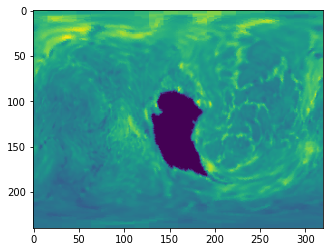

In [ ]:
# File input/output/visualisation

dirname='/content/drive/MyDrive/coursework1-data-2022-pma'

example_im=np.load(os.path.join(dirname,'2D_projection_L_sub-0.npy'))

meta_path='/content/drive/MyDrive/meta_2022_pma.pkl'
label_df=pd.read_pickle(meta_path)

plt.imshow(example_im[:,:,0])

print('subject meta data', label_df.iloc[0])
print('example shapea ', example_im.shape)


# **DataSet and DataLoaders**

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dirname, meta_path, transform=None):
        self.dirname = dirname
        self.meta_path = meta_path
        self.transform = transform
        self.labels = pd.read_pickle(self.meta_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        subject_id = self.labels.iloc[index]['subj_id']
        scan_pma = self.labels.iloc[index]['scan_pma']

        # Load image data
        image_path = os.path.join(self.dirname, f'2D_projection_L_sub-{subject_id}.npy')
        image_data = np.load(image_path)

        # Apply transform if provided
        if self.transform:
            image_data = self.transform(image_data)

        # Convert data to PyTorch tensor
        image_tensor = torch.from_numpy(image_data).to(torch.float)

        # Reshape image tensor to CxHxW format
        image_tensor = image_tensor.permute(2, 0, 1)

        # Create label tensor
        label_tensor = torch.tensor(scan_pma).to(torch.float)

        return image_tensor, label_tensor

Dataset length: 476
Batch shape: torch.Size([32, 4, 240, 320])
Label shape: torch.Size([32])


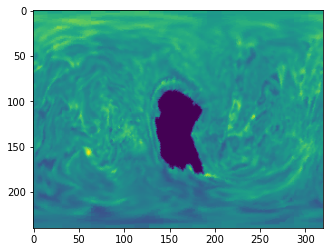

In [ ]:
# Create dataset
dataset = CustomDataset(dirname, meta_path)

# Print length of dataset
print(f"Dataset length: {len(dataset)}")

# Define train and validation set samplers
train_sampler = SubsetRandomSampler(list(range(425)))
valid_sampler = SubsetRandomSampler(list(range(425, 476)))

# Create train and validation data loaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=len(valid_sampler), sampler=valid_sampler)

# Test train loader by printing shape and plotting one batch
batch = next(iter(train_loader))
images, labels = batch

# Print the shape of the batch
print('Batch shape:', images.shape)
print('Label shape:', labels.shape)

# Plot one image from the batch
plt.imshow(images[0][0])
plt.show()

# **Pre-activation ResNet**


Implement preactivation residual blocks following the implementation in the 2016 paper He 2016

In [ ]:
class PreactBasicResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, preactivate=True):
        super(PreactBasicResidualBlock, self).__init__()
        self.pre_bn = self.pre_relu = None
        if preactivate:
            self.pre_bn = nn.BatchNorm2d(inplanes)
            self.pre_relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1_2 = nn.BatchNorm2d(planes)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes,kernel_size=3, stride=1, padding=1, bias=False)
        self.downsample = downsample
        self.stride = stride
        self.preactivate = preactivate

    def forward(self, x):
        if self.preactivate:
            preact = self.pre_bn(x)
            preact = self.pre_relu(preact)
        else:
            preact = x

        out = self.conv1(preact)
        out = self.bn1_2(out)
        out = self.relu1_2(out)
        out = self.conv2(out)

        if self.downsample is not None:
            residual = self.downsample(preact)
        else:
            residual = x

        out += residual

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.final_bn = nn.BatchNorm2d(512 * block.expansion)
        self.final_relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(4096 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
            )

        # On the first residual block in the first residual layer, it don't pre-activate,
        preactivate_first = stride != 1

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, preactivate_first))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.final_bn(x)
        x = self.final_relu(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
def PreactResNet34():
    return ResNet(PreactBasicResidualBlock, [3, 4, 6, 3], num_classes=1)

# **Train for prediction of postmenstrual age at scan**

Age at scan is a strong phenotype since the appearance of babies brains change dramatically over the first few weeks of life. This experiment can therefore be seen as a baseline from which to optimise performance of your network prior to training on birth age (which is more difficult)

In [ ]:
resnet = PreactResNet34()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

learning_rate = 0.01
num_epochs = 10
loss_fn = torch.nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
summary(resnet,input_size=(4, 240, 320),batch_size=32)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 120, 160]          12,544
       BatchNorm2d-2         [32, 64, 120, 160]             128
              ReLU-3         [32, 64, 120, 160]               0
         MaxPool2d-4           [32, 64, 60, 80]               0
            Conv2d-5           [32, 64, 60, 80]          36,864
       BatchNorm2d-6           [32, 64, 60, 80]             128
              ReLU-7           [32, 64, 60, 80]               0
            Conv2d-8           [32, 64, 60, 80]          36,864
  PreactBasicBlock-9           [32, 64, 60, 80]               0
      BatchNorm2d-10           [32, 64, 60, 80]             128
             ReLU-11           [32, 64, 60, 80]               0
           Conv2d-12           [32, 64, 60, 80]          36,864
    

Epoch: 0, Train Loss: 231.4049, Val Loss: 47659372.0000
Epoch: 1, Train Loss: 6.1837, Val Loss: 107672.4531
Epoch: 2, Train Loss: 1.8888, Val Loss: 5181.8423
Epoch: 3, Train Loss: 1.4700, Val Loss: 74.7606
Epoch: 4, Train Loss: 1.3799, Val Loss: 3.4746
Epoch: 5, Train Loss: 1.0637, Val Loss: 1.5839
Epoch: 6, Train Loss: 1.2159, Val Loss: 1.7714
Epoch: 7, Train Loss: 1.0841, Val Loss: 1.4404
Epoch: 8, Train Loss: 1.1087, Val Loss: 1.4025
Epoch: 9, Train Loss: 1.0811, Val Loss: 1.4647


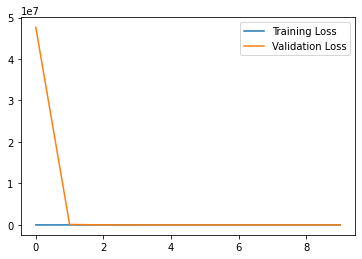

In [ ]:
# Train and validation over 10 epochs
def train(resnet, train_loader, loss_fn, optimizer, device):
    resnet.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape(-1,1)

        optimizer.zero_grad()

        outputs = resnet(images)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / (len(train_loader) * train_loader.batch_size)
    return train_loss

def validate(resnet, valild_loader, loss_fn, device):
    resnet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.reshape(-1,1)

            outputs = resnet(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / (len(valid_loader) * valid_loader.batch_size)
    return val_loss

num_epochs = 10
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    train_loss = train(resnet, train_loader, loss_fn, optimizer, device)
    val_loss = validate(resnet, valid_loader, loss_fn, device)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    scheduler.step()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.show()

# **Augmentations & Optimise**


*   Add Gaussian random noise
*   Simulate elastic deformations

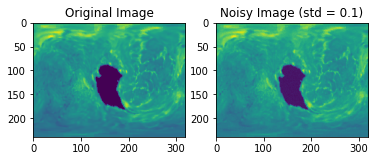

In [ ]:
# Gaussian transform class
class GaussianNoiseTransform:
    def __init__(self, std):
        self.std = std

    def __call__(self, image):
        noisy_image = image + np.random.normal(loc=0, scale=self.std, size=image.shape)
        return noisy_image

image = example_im[:,:,0]
gaussian_noise = GaussianNoiseTransform(0.1)
noisy_image = gaussian_noise(image)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image)
ax1.set_title('Original Image')
ax2.imshow(noisy_image)
ax2.set_title('Noisy Image (std = {})'.format(0.1))
plt.show()

In [ ]:
print(len(example_im[:,:,0].shape))

2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


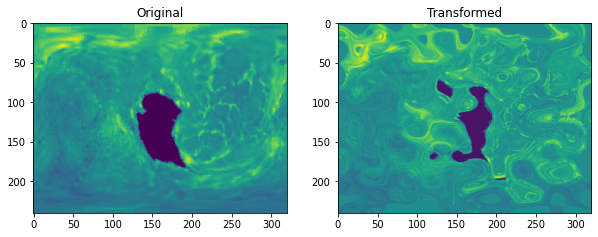

In [ ]:
# Apply elastic deformation using the deform_random_grid function from the elasticdeform package
!pip install elasticdeform
import elasticdeform

class ElasticTransform:
    def __init__(self, displacement=25, smoothness=10):
        self.displacement = displacement
        self.smoothness = smoothness

    def __call__(self, img):
        img_shape = img.shape
        if len(img_shape) < 3:
            # if input is single channel, add a channel dimension
            img = img[..., np.newaxis]
        transformed_img = np.zeros_like(img)
        for i in range(img.shape[-1]):
            transformed_img[..., i] = elasticdeform.deform_random_grid(
                img[..., i], sigma=self.displacement, points=self.smoothness
            )
        return transformed_img.squeeze()

# Load a test image
image = example_im[:,:,0]

# Create an instance of the ElasticTransform class with displacement=20 and smoothness=15
elastic_transform = ElasticTransform(displacement=20, smoothness=15)

# Apply the ElasticTransform
transformed_image = elastic_transform(image)

# Plot the original and transformed images side by side
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original")
ax[1].imshow(transformed_image)
ax[1].set_title("Transformed")
plt.show()

In [ ]:
# Compose transform
transform = transforms.Compose([
    GaussianNoiseTransform(0.1),
    ElasticTransform(displacement=20, smoothness=15)])

# Update the dataloaders
train_sampler = SubsetRandomSampler(list(range(425)))
valid_sampler = SubsetRandomSampler(list(range(425, 476)))

new_train_dataset = CustomDataset(dirname, meta_path,  transform=transform)
new_valid_dataset = CustomDataset(dirname, meta_path)

new_train_loader = torch.utils.data.DataLoader(new_train_dataset, batch_size=32, sampler=train_sampler)
new_valid_loader = torch.utils.data.DataLoader(new_valid_dataset, batch_size=len(valid_sampler), sampler=valid_sampler)

Epoch: 0, Train Loss: 202.7579, Val Loss: 1140.6235
Epoch: 1, Train Loss: 7.4109, Val Loss: 42.2833
Epoch: 2, Train Loss: 4.4754, Val Loss: 9.7307
Epoch: 3, Train Loss: 3.5801, Val Loss: 12.6163
Epoch: 4, Train Loss: 3.3478, Val Loss: 16.0758
Epoch: 5, Train Loss: 3.3165, Val Loss: 29.2946
Epoch: 6, Train Loss: 2.9486, Val Loss: 19.2968
Epoch: 7, Train Loss: 3.1932, Val Loss: 34.4276
Epoch: 8, Train Loss: 2.4755, Val Loss: 13.7296
Epoch: 9, Train Loss: 2.9058, Val Loss: 24.9450


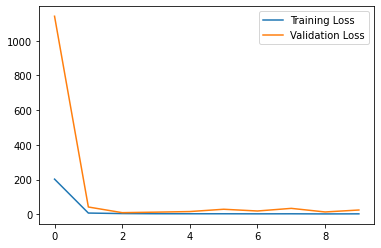

In [ ]:
# Retrain the network
def train(resnet, new_train_loader, loss_fn, optimizer, device):
    resnet.train()
    train_loss = 0.0
    for images, labels in new_train_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape(-1,1)

        optimizer.zero_grad()

        outputs = resnet(images)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / (len(new_train_loader) * new_train_loader.batch_size)
    return train_loss

def validate(resnet, new_valid_loader, loss_fn, device):
    resnet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in new_valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.reshape(-1,1)

            outputs = resnet(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / (len(new_valid_loader) * new_valid_loader.batch_size)
    return val_loss

num_epochs = 10
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    train_loss = train(resnet, new_train_loader, loss_fn, optimizer, device)
    val_loss = validate(resnet, new_valid_loader, loss_fn, device)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Optimise
class PreactBnResidualBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, preactivate=True):
        super(PreactBnResidualBlock, self).__init__()
        self.pre_bn = self.pre_relu = None
        if preactivate:
            self.pre_bn = nn.BatchNorm2d(inplanes)
            self.pre_relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1_2 = nn.BatchNorm2d(planes)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2_3 = nn.BatchNorm2d(planes)
        self.relu2_3 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.downsample = downsample
        self.stride = stride
        self.preactivate = preactivate

    def forward(self, x):
        if self.preactivate:
            preact = self.pre_bn(x)
            preact = self.pre_relu(preact)
        else:
            preact = x

        out = self.conv1(preact)
        out = self.bn1_2(out)
        out = self.relu1_2(out)

        out = self.conv2(out)
        out = self.bn2_3(out)
        out = self.relu2_3(out)

        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(preact)
        else:
            residual = x

        out += residual

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.final_bn = nn.BatchNorm2d(512 * block.expansion)
        self.final_relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(4096 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
            )

        # On the first residual block in the first residual layer, it don't pre-activate,
        preactivate_first = stride != 1

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, preactivate_first))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.final_bn(x)
        x = self.final_relu(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
def PreactResNet50():
    return ResNet(PreactBnResidualBlock, [3, 4, 6, 3], num_classes=1)

In [ ]:
resnet = PreactResNet50()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# Initialize weights
import torch.nn.init as init
for name, param in resnet.named_parameters():
    if 'conv' in name and 'weight' in name:
        init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')
    elif 'bn' in name and 'weight' in name:
        init.constant_(param, 1)
    elif 'bn' in name and 'bias' in name:
        init.constant_(param, 0)
    elif 'fc' in name and 'weight' in name:
        init.normal_(param, std=0.001)
    elif 'fc' in name and 'bias' in name:
        init.constant_(param, 0)

# Create loss functon and optimiser
from torch.optim.lr_scheduler import StepLR
learning_rate = 0.01
num_epochs = 50
loss_fn = torch.nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
summary(resnet,input_size=(4, 240, 320),batch_size=32)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 120, 160]          12,544
       BatchNorm2d-2         [32, 64, 120, 160]             128
              ReLU-3         [32, 64, 120, 160]               0
         MaxPool2d-4           [32, 64, 60, 80]               0
            Conv2d-5           [32, 64, 60, 80]           4,096
       BatchNorm2d-6           [32, 64, 60, 80]             128
              ReLU-7           [32, 64, 60, 80]               0
            Conv2d-8           [32, 64, 60, 80]          36,864
       BatchNorm2d-9           [32, 64, 60, 80]             128
             ReLU-10           [32, 64, 60, 80]               0
           Conv2d-11          [32, 256, 60, 80]          16,384
           Conv2d-12          [32, 256, 60, 80]          16,384
 Pre

Epoch: 0, Train Loss: 384.7004, Val Loss: 7916883.0000
Epoch: 1, Train Loss: 12.3265, Val Loss: 3567.8672
Epoch: 2, Train Loss: 5.1748, Val Loss: 193.6661
Epoch: 3, Train Loss: 1.8274, Val Loss: 15.2703
Epoch: 4, Train Loss: 1.6116, Val Loss: 2.3429
Epoch: 5, Train Loss: 1.8549, Val Loss: 1.8881
Epoch: 6, Train Loss: 1.8218, Val Loss: 2.6471
Epoch: 7, Train Loss: 2.1959, Val Loss: 1.9989
Epoch: 8, Train Loss: 2.0884, Val Loss: 2.4354
Epoch: 9, Train Loss: 1.7838, Val Loss: 3.0052
Epoch: 10, Train Loss: 2.4501, Val Loss: 8.3842
Epoch: 11, Train Loss: 4.5351, Val Loss: 2.8657
Epoch: 12, Train Loss: 1.1393, Val Loss: 1.6414
Epoch: 13, Train Loss: 3.0510, Val Loss: 1.7569
Epoch: 14, Train Loss: 1.8844, Val Loss: 1.5554
Epoch: 15, Train Loss: 1.2038, Val Loss: 2.2099
Epoch: 16, Train Loss: 1.0353, Val Loss: 2.8024
Epoch: 17, Train Loss: 1.7064, Val Loss: 1.3046
Epoch: 18, Train Loss: 1.4316, Val Loss: 1.0705
Epoch: 19, Train Loss: 0.8617, Val Loss: 1.2116
Epoch: 20, Train Loss: 1.0076, Val 

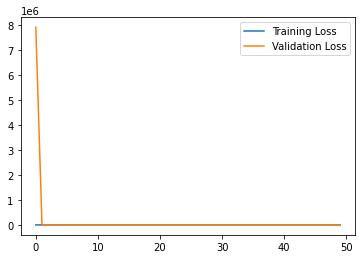

In [ ]:
# Train
def train(resnet, train_loader, loss_fn, optimizer, device):
    resnet.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape(-1,1)

        optimizer.zero_grad()

        outputs = resnet(images)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / (len(train_loader) * train_loader.batch_size)
    return train_loss

def validate(resnet, valild_loader, loss_fn, device):
    resnet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.reshape(-1,1)

            outputs = resnet(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / (len(valid_loader) * valid_loader.batch_size)
    return val_loss

num_epochs = 50
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    train_loss = train(resnet, train_loader, loss_fn, optimizer, device)
    val_loss = validate(resnet, valid_loader, loss_fn, device)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    scheduler.step()
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.show()

*Report:*

Previously I tested the data for training using the Resnet34 model architecture, using to the Adam optimiser, due to the superior performance of the Adam optimiser when compared to the SGD optimiser. I set the hyperparameter 'weight decay' within the Adam optimiser to 0.001 to control the strength of the regularisation. I also introduced the sheduler to implement an adaptive reduction in the learning rate during training (starting from a predefined 0.01). In the training loop I call the method sheduler.step() to update the learning rate according to a predefined schedule. Also epoch is set to 10 and step size is set to 5, meaning that the learning rate will decrease by a factor of 0.1 after every 5 epochs. This is because I chose a smaller step_size value that might be more appropriate based on the premise that the ResNet34 model converges quickly and the dataset is small. This brings the validation loss down to around 1.0 at 10 epochs.

Using a combination of Gaussian noise and elastic augmentation in the 10 epochs, the training results were not as good as if no combination of transformations had been added. This may be due to the fact that the use of Gaussian noise and elastic augmentation has some effect on the data during training, making the network performance lower.

In the optimisation section, I did not continue to use a combination of Gaussian noise and elasticity enhancement. Instead, I made changes to the model structure: Turning the original ResNet34 into ResNet50 makes the dataset larger and convergence becomes relatively slow, but the network is deeper, which will be more effective for training. I introduced the weight initialisation mentioned by Kaiming He in his paper and made changes to accommodate the model and data. The weights of the convolutional layer are initialised using a normal initialisation with non-linearity. The weights of the batch normalisation layer are initialised with the constant values 1 (scaling parameter) and 0 (deviation parameter), which is the standard initialisation for batch normalisation layers. The weights for the fully connected layer are initialised using a normal distribution with a standard deviation of 0.001 and the bias term is initialised to a constant value of 0. This helps the model to converge faster and gives better performance. The optimiser is still using the Adam optimiser, but the difference is that I set the hyperparameter 'weight decay' to 0.0001, which helps a lot to improve the model performance. The scheduler was still applied to adaptively reduce the learning rate during training from the initial setting of 0.01. In the optimisation, I set the epoch to 50, which increases the time and number of training sessions, and the step size to 10, which means that the learning rate will decrease by a factor of 0.1 after every 10 epochs. Based on the training losses and validation losses in the performance evaluation of the training, it was shown that my optimisation was effective. The validation loss was eventually reduced to below 0.9 in 50 epochs, but there was still some overfitting.

# **Visualisation with occlusion**

Next use occlusion analysis to determine which parts of the image are most important for the prediction. Plot the resulting heatmap for the first 5 images from the validation batch.



In [ ]:
def occlude_image(image, height_centre,width_centre,patch_size):

    # Make a new copy of image in memory;
    occluded_image = image.detach().clone()

    # Estimate the start and end dimensions of the patch
    height_start=int(height_centre-ceil(patch_size/2))
    width_start=int(width_centre-ceil(patch_size/2))

    if height_start <0:
      height_start=0
    if width_start < 0:
      width_start=0

    height_end=height_start+patch_size
    width_end=width_start+patch_size

    if height_end >= occluded_image.shape[1]:
      height_end=occluded_image.shape[1]-1
    if width_end >= occluded_image.shape[2]:
      width_end=occluded_image.shape[2]-1

    # Use the parameters supplied to determined patch coordinates
    occluded_image[:,height_start:height_end,width_start:width_end]=0.5

    return occluded_image

In [ ]:
def occlusion_reg(model, image, occ_size=50, occ_pixel=0.5):

    # Create a zero image with the shape of the input image.
    heatmap = torch.zeros(image.shape[1], image.shape[2])

    # Iterate over all the pixels in each column.
    for h in range(image.shape[1]):
        for w in range(image.shape[2]):
            # Occlude the image for this patch.
            occluded_image = occlude_image(image, h, w, occ_size)
            # Make a forward pass through the model and return the regression output.
            output_occluded = model(occluded_image.unsqueeze(0))
            # Set the heatmap location to the regression output value.
            heatmap[h, w] = output_occluded.item()

    return heatmap

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

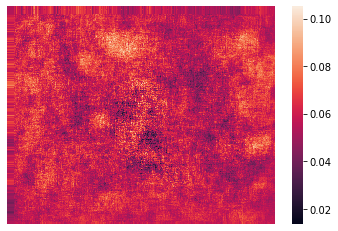

In [ ]:
# Load the validation dataset
dataset = CustomDataset(dirname, meta_path)
valid_sampler = SubsetRandomSampler(list(range(425, 476)))
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=len(valid_sampler), sampler=valid_sampler)
images, labels = next(iter(valid_loader))
images = images.to(device)
resnet = PreactResNet50()
resnet = resnet.to(device)
heatmap = occlusion_reg(resnet, images[0], occ_size = 15)

heatmap = sns.heatmap(heatmap.detach().numpy(), xticklabels=False, yticklabels=False)

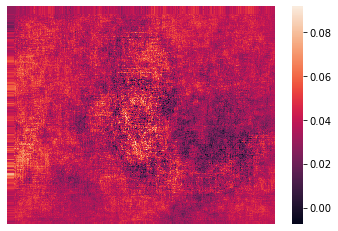

In [ ]:
heatmap = occlusion_reg(resnet, images[1], occ_size = 15)

heatmap = sns.heatmap(heatmap.detach().numpy(), xticklabels=False, yticklabels=False)


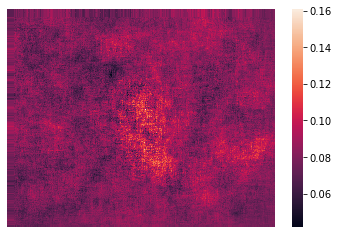

In [ ]:
heatmap = occlusion_reg(resnet, images[2], occ_size = 15)

heatmap = sns.heatmap(heatmap.detach().numpy(), xticklabels=False, yticklabels=False)


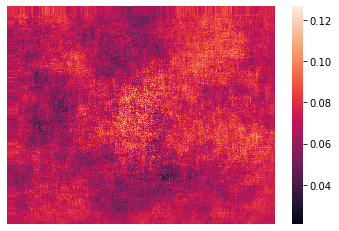

In [ ]:
heatmap = occlusion_reg(resnet, images[3], occ_size = 15)

heatmap = sns.heatmap(heatmap.detach().numpy(), xticklabels=False, yticklabels=False)


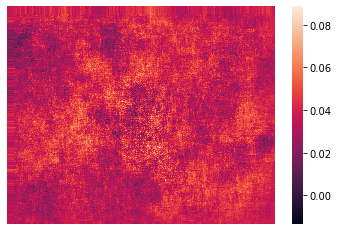

In [ ]:
heatmap = occlusion_reg(resnet, images[4], occ_size = 15)

heatmap = sns.heatmap(heatmap.detach().numpy(), xticklabels=False, yticklabels=False)


# **Birth Age Prediction**

In this last part of the project, I will try to solve a more difficult prediction task: prediction of the **birth age** of babies scanned as part of the Developing Human Connectome Project. For this, I will be using a new subset of the dhcp data with the same metrics as previously.

Additionally, I will explore the problem of dealing with confounds in medical imaging; the task of birth age prediction being highly impacted by the apparence of the scan and thus the postmenstrual age at scan. Therefore, to improve predictions of birth age I will try to incorporate that information in the training process.

Another key point to make here is that the data is imbalanced - while not a classification problem this can be addressed by noting that samples are much fewer for babies with birth ages below 37 weeks.

## **New pipeline for Gestational Age predictions and train a network**

- First adapt the existing dataset class to return the image with GA as the label
- Create dataloaders for training and validation - with the first 411 subjects for training and the 51 remaining for valiation.
- Train a model for 10 epochs. Observe the differences in performance compared to the previous task of gestational age at scan prediction

subj_id         0
scan_ga     40.14
scan_pma     44.0
Name: 0, dtype: object


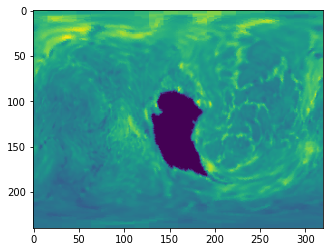

In [ ]:
dirname='/content/drive/MyDrive/coursework1-data-2022-ga'

example_im=np.load(os.path.join(dirname,'2D_projection_L_sub-0.npy'))

meta_path='/content/drive/MyDrive/meta_2022_ga.pkl'
label_df=pd.read_pickle(meta_path)

plt.imshow(example_im[:,:,0])

print(label_df.iloc[0])

In [ ]:
# Adapt existing dataset class to return the image with GA as the label
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dirname, meta_path, transform=None):
        self.dirname = dirname
        self.meta_path = meta_path
        self.transform = transform
        self.labels = pd.read_pickle(self.meta_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        subject_id = self.labels.iloc[index]['subj_id']
        scan_ga = self.labels.iloc[index]['scan_ga']

        # Load image data
        image_path = os.path.join(self.dirname, f'2D_projection_L_sub-{subject_id}.npy')
        image_data = np.load(image_path)

        # Apply transform if provided
        if self.transform:
            image_data = self.transform(image_data)

        # Convert data to PyTorch tensor
        image_tensor = torch.from_numpy(image_data).to(torch.float)

        # Reshape image tensor to CxHxW format
        image_tensor = image_tensor.permute(2, 0, 1)

        # Create label tensor
        label_tensor = torch.tensor(scan_ga).to(torch.float)

        return image_tensor, label_tensor

In [ ]:
# Create datasets
dataset = CustomDataset(dirname, meta_path)

# Define train and validation set samplers
train_sampler = SubsetRandomSampler(list(range(411)))
valid_sampler = SubsetRandomSampler(list(range(411, 462)))

# Create train and validation data loaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=len(valid_sampler), sampler=valid_sampler)
images, labels = next(iter(train_loader))

In [ ]:
resnet = PreactResNet34()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)


# Create loss function and optimiser
learning_rate = 0.01
num_epochs = 10
loss_fn = torch.nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
resnet = PreactResNet50()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# Initialize weights
import torch.nn.init as init
for name, param in resnet.named_parameters():
    if 'conv' in name and 'weight' in name:
        init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')
    elif 'bn' in name and 'weight' in name:
        init.constant_(param, 1)
    elif 'bn' in name and 'bias' in name:
        init.constant_(param, 0)
    elif 'fc' in name and 'weight' in name:
        init.normal_(param, std=0.001)
    elif 'fc' in name and 'bias' in name:
        init.constant_(param, 0)

# Create loss function and optimiser
learning_rate = 0.01
num_epochs = 10
loss_fn = torch.nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Train the PreactResNet50
for epoch in range(num_epochs):
    # Train on the training dataset
    resnet.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.reshape(-1,1)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= (len(train_loader) * train_loader.batch_size)

    # Evaluate on the validation dataset
    resnet.eval()
    val_loss = 0.0
    with torch.no_grad():
      for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.reshape(-1,1)
            labels = labels.to(device)

            outputs = resnet(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= (len(valid_loader) * valid_loader.batch_size)

    # Print the training and validation loss for each epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss))

    scheduler.step()

Epoch [1/10], Train Loss: 274.2460, Val Loss: 222580.6562
Epoch [2/10], Train Loss: 8.9002, Val Loss: 62.9231
Epoch [3/10], Train Loss: 5.3877, Val Loss: 59.8571
Epoch [4/10], Train Loss: 3.7854, Val Loss: 14.2223
Epoch [5/10], Train Loss: 2.8038, Val Loss: 4.9518
Epoch [6/10], Train Loss: 2.6193, Val Loss: 4.7546
Epoch [7/10], Train Loss: 2.6134, Val Loss: 4.8101
Epoch [8/10], Train Loss: 2.2570, Val Loss: 4.8986
Epoch [9/10], Train Loss: 2.2981, Val Loss: 4.9574
Epoch [10/10], Train Loss: 2.1686, Val Loss: 4.9455


In [ ]:
# Train the PreactResNet34
for epoch in range(num_epochs):
    # Train on the training dataset
    resnet.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.reshape(-1,1)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= (len(train_loader) * train_loader.batch_size)

    # Evaluate on the validation dataset
    resnet.eval()
    val_loss = 0.0
    with torch.no_grad():
      for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.reshape(-1,1)
            labels = labels.to(device)

            outputs = resnet(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= (len(valid_loader) * valid_loader.batch_size)

    # Print the training and validation loss for each epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss))

    scheduler.step()

Epoch [1/10], Train Loss: 584.0714, Val Loss: 5951936.0000
Epoch [2/10], Train Loss: 16.7323, Val Loss: 4458.8701
Epoch [3/10], Train Loss: 9.5913, Val Loss: 8493.0508
Epoch [4/10], Train Loss: 7.8235, Val Loss: 65.1354
Epoch [5/10], Train Loss: 4.1185, Val Loss: 6.2768
Epoch [6/10], Train Loss: 3.2981, Val Loss: 7.1628
Epoch [7/10], Train Loss: 2.8227, Val Loss: 6.3026
Epoch [8/10], Train Loss: 2.5486, Val Loss: 8.1242
Epoch [9/10], Train Loss: 1.8343, Val Loss: 6.0540
Epoch [10/10], Train Loss: 1.7578, Val Loss: 5.9785


## **New Dataset for Gestational Age predictions with confounds**

In [ ]:
class CustomDatasetWithConfounds(torch.utils.data.Dataset):
    def __init__(self, dirname, meta_path, transform=None):
        self.dirname = dirname
        self.meta_path = meta_path
        self.transform = transform
        self.labels = pd.read_pickle(self.meta_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        subject_id = self.labels.iloc[index]['subj_id']
        birth_age = self.labels.iloc[index]['scan_ga']
        scan_age = self.labels.iloc[index]['scan_pma']

        # Load image data
        image_path = os.path.join(self.dirname, f'2D_projection_L_sub-{subject_id}.npy')
        image_data = np.load(image_path)

        # Apply transform if provided
        if self.transform:
            image_data = self.transform(image_data)

        # Convert data to PyTorch tensor
        image_tensor = torch.from_numpy(image_data).to(torch.float)

        # Reshape image tensor to CxHxW format
        image_tensor = image_tensor.permute(2, 0, 1)

        # Create label tensors
        birth_age_tensor = torch.tensor([birth_age]).to(torch.float)
        scan_age_tensor = torch.tensor([scan_age]).to(torch.float)

        return image_tensor, birth_age_tensor, scan_age_tensor

In [ ]:
# Define a custom collate function to handle variable size of images
def collate_fn(batch):
    images = []
    birth_ages = []
    scan_ages = []
    for sample in batch:
        images.append(sample[0])
        birth_ages.append(sample[1])
        scan_ages.append(sample[2])
    images = torch.stack(images, dim=0)
    birth_ages = torch.stack(birth_ages, dim=0)
    scan_ages = torch.stack(scan_ages, dim=0)
    return images, birth_ages, scan_ages

# Create datasets
dataset = CustomDatasetWithConfounds(dirname, meta_path)
print(dataset.labels.keys())

# Define train and validation set samplers
train_indices = list(range(411))
valid_indices = list(range(411, 462))
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# Define the data loaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_sampler, collate_fn=collate_fn, num_workers=2, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=len(valid_sampler), sampler=valid_sampler, collate_fn=collate_fn, num_workers=2, pin_memory=True)

# Get the birth age values for all samples in the training dataset
train_birth_ages = [dataset.labels.iloc[i]['scan_ga'] for i in train_indices]

# Compute the class weights based on the frequency of birth ages in the training dataset
class_weights = 1.0 / np.array([(np.sum(np.array(train_birth_ages) >= 37) / len(train_birth_ages)), (np.sum(np.array(train_birth_ages) < 37) / len(train_birth_ages))])

# Compute the weights for each sample in the training dataset
sample_weights = [class_weights[int(age < 37)] for age in train_birth_ages]

# Create a weighted sampler to oversample the minority class during training
train_sampler_weighted = WeightedRandomSampler(sample_weights, len(train_indices), replacement=True)

# Set the train sampler to the weighted sampler
train_loader.batch_sampler.sampler = train_sampler_weighted

images, birth_ages, scan_ages = next(iter(train_loader))

Index(['subj_id', 'scan_ga', 'scan_pma'], dtype='object')


In [ ]:
print('image shape:', images.shape)
print('birth age shape:', birth_ages.shape)
print('scan age shape:', scan_ages.shape)

image shape: torch.Size([32, 4, 240, 320])
birth age shape: torch.Size([32, 1])
scan age shape: torch.Size([32, 1])


## **ResNet to deconfound Gestational Age predictions with age at scan**

Prediction of gestational age at birth is a more difficult task than scan age prediction. Indeed, this task is highly correlated to the PMA at scan. Therefore, to improve GA predictions, I decide to modify my ResNet model to incorporate scan age information into the model before the last linear layer.



In [ ]:
class ResNetDeconfounded(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        self.inplanes = 64
        super(ResNetDeconfounded, self).__init__()
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.final_bn = nn.BatchNorm2d(512 * block.expansion)
        self.final_relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(4096 * block.expansion, 512)
        self.fc2 = nn.Linear(512 + 1, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
            )

        # On the first residual block in the first residual layer, it don't pre-activate,
        preactivate_first = stride != 1

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, preactivate_first))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, scan_age):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.final_bn(x)
        x = self.final_relu(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        scan_age = scan_age.view(scan_age.size(0), -1)
        x = torch.cat((x, scan_age), dim=1)
        x = self.fc2(x)

        return x


## **Train and optimise**


In [ ]:
def DeconfoundedResNet34():
    return ResNetDeconfounded(PreactBasicResidualBlock, [3, 4, 6, 3], num_classes=1)

In [ ]:
def DeconfoundedResNet50():
    return ResNetDeconfounded(PreactBnResidualBlock, [3, 4, 6, 3], num_classes=1)

In [ ]:
resnet = DeconfoundedResNet50()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# Initialize weights
import torch.nn.init as init
for name, param in resnet.named_parameters():
    if 'conv' in name and 'weight' in name:
        init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')
    elif 'bn' in name and 'weight' in name:
        init.constant_(param, 1)
    elif 'bn' in name and 'bias' in name:
        init.constant_(param, 0)
    elif 'fc' in name and 'weight' in name:
        init.normal_(param, std=0.001)
    elif 'fc' in name and 'bias' in name:
        init.constant_(param, 0)

# Define the loss function and optimizer
learning_rate = 0.001
num_epochs = 50
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=0.0001)
# optimizer = torch.optim.AdamW(resnet.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = torch.optim.RMSprop(resnet.parameters(), lr=learning_rate, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.L1Loss()
loss_fn = loss_fn.to(device)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
# Train the model
for epoch in range(num_epochs):
    # Train on the training dataset
    resnet.train()
    train_loss = 0.0
    for images, birth_ages, scan_ages in train_loader:
        images = images.to(device)
        scan_ages = scan_ages.to(device)
        birth_ages = birth_ages.to(device)
        scan_ages = scan_ages.reshape(-1,1)

        optimizer.zero_grad()
        outputs = resnet(images, scan_ages)
        loss = loss_fn(outputs, birth_ages)
        deconfounding_term = torch.abs(outputs - birth_ages) * torch.abs(scan_ages - 40) # Assume the median gestational age at birth is 40 week
        loss += 0.1 * deconfounding_term.mean()  # Add deconfounding term to the loss

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= (len(train_loader) * train_loader.batch_size)

    # Evaluate on the validation dataset
    resnet.eval()
    val_loss = 0.0
    with torch.no_grad():
      for images, birth_ages, scan_ages in valid_loader:
            images = images.to(device)
            scan_ages = scan_ages.to(device)
            birth_ages = birth_ages.to(device)
            scan_ages = scan_ages.reshape(-1,1)

            outputs = resnet(images, scan_ages)
            loss = loss_fn(outputs, birth_ages)
            deconfounding_term = torch.abs(outputs - birth_ages) * torch.abs(scan_ages - 40) # Assume the median gestational age at birth is 40 week
            loss += 0.1 * deconfounding_term.mean()  # Add deconfounding term to the loss

            val_loss += loss.item() * images.size(0)
    val_loss /= (len(valid_loader) * valid_loader.batch_size)

    # Print the training and validation loss for each epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss))

    scheduler.step()

Epoch [1/50], Train Loss: 303.0095, Val Loss: 138112.1875
Epoch [2/50], Train Loss: 15.5244, Val Loss: 4328.7681
Epoch [3/50], Train Loss: 4.3846, Val Loss: 210.1889
Epoch [4/50], Train Loss: 3.7914, Val Loss: 36.7235
Epoch [5/50], Train Loss: 3.9738, Val Loss: 5.3883
Epoch [6/50], Train Loss: 3.9738, Val Loss: 9.3137
Epoch [7/50], Train Loss: 2.4487, Val Loss: 4.0432
Epoch [8/50], Train Loss: 2.6453, Val Loss: 7.3197
Epoch [9/50], Train Loss: 4.5580, Val Loss: 4.6343
Epoch [10/50], Train Loss: 3.3501, Val Loss: 3.9244
Epoch [11/50], Train Loss: 1.1831, Val Loss: 4.0444
Epoch [12/50], Train Loss: 1.3461, Val Loss: 3.7050
Epoch [13/50], Train Loss: 1.1285, Val Loss: 3.6515
Epoch [14/50], Train Loss: 1.4477, Val Loss: 5.1904
Epoch [15/50], Train Loss: 0.7125, Val Loss: 3.6686
Epoch [16/50], Train Loss: 0.7155, Val Loss: 3.9172
Epoch [17/50], Train Loss: 0.4903, Val Loss: 3.5178
Epoch [18/50], Train Loss: 0.7887, Val Loss: 3.5328
Epoch [19/50], Train Loss: 1.4269, Val Loss: 3.4638
Epoch [

*Report:*



Firstly, I created a dataset that returned 3 tensors, and then custom collation functions were used to stack the image tensors with the corresponding birth age and scan age tensors into batches for efficient training. By using WeightedRandomSampler, the training sampler is made to be a weighted sampler which oversamples a small number of classes (birth ages less than 37 weeks) to address the class imbalance. Also, class weights are calculated based on the frequency of age at birth in the training dataset, and sample weights are calculated based on the class weight and age at birth for each sample in the training dataset.

Secondly, in this model definition section, I still used the ResNet50 model architecture, but the difference is that I modified the ResNet50 model with pre-activation defined in the previous section on predicting scan age to include a batch of 4-channel images (the fourth channel represents the confounding variable) and a corresponding batch of scan ages as input in the pre-activation function. In the final layers of the model, I added another fully-connected layer with one output feature, and in the forward approach the input was passed through a convolution and residual layer to generate the feature representation. The feature representation is then passed through a final layer, including a connection to the scan age, to produce a single output value.

Finally, in the training part, the ResNet model learns this information to better predict the age at birth by passing the scan age tensor as an additional input to the ResNet model and adding a deconfounding term to the loss function to reduce the effect of the scan age on predicting the age at birth. The absolute difference between the model output and the target age at birth is multiplied by the absolute difference between the scan age and the median gestational age at birth (assumed to be 40 weeks). The resulting term was then added to the loss function and weighted by the hyperparameter (0.1). By including this term in the loss function, the model is encouraged to learn a mapping between the input image and the age at birth that is less influenced by the age at scan, which helps to improve the accuracy of the prediction.

In summary, with this implementation, it is possible to achieve the elimination of confounding of gestational age prediction with age at scan and evaluate the results by training with an epoch of 50, with the validation loss oscillating down to around 3.0 over 50 epochs. As I iteratively adjusted the hyperparameters and loss functions, as well as the choice of optimiser, this did not result in a validation loss of around 1.0. Coupled with the fact that I had reached the upper limit of GPU usage for my Google Colab, I used this oscillating validation loss of around 3.0 as the final metric for evaluating the performance of my model.
